In [21]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt





%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [22]:
from fbprophet import Prophet

In [23]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Trivial forcast (Rolling mean)

In [25]:
df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [26]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


# Small Dataset

In [30]:

df_all = pd.read_csv('../data/processed/COVID_small_flat_table1.csv')
df=df_all[['date','France']]
df=df.rename(columns={'date': 'ds',
                        'France': 'y'})

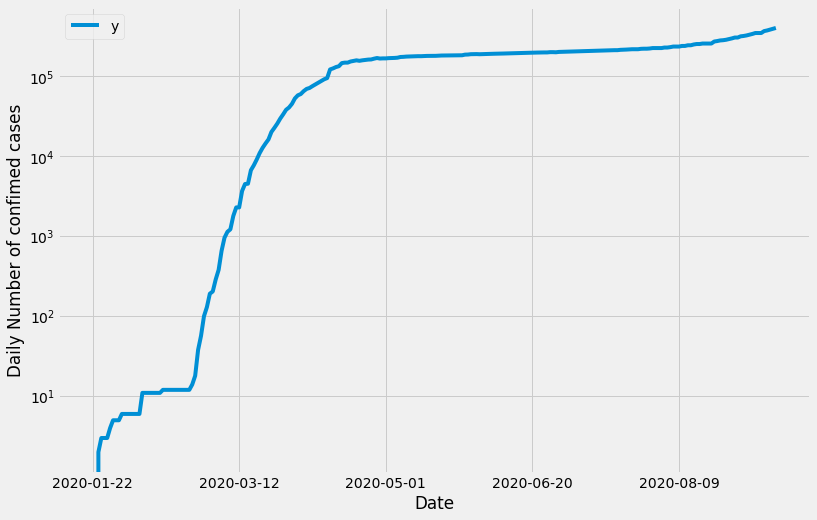

In [31]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [32]:
my_model = Prophet(growth='logistic')   # logistic model

In [33]:
df['cap']=1000000.
my_model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
236,2020-09-14,1000000.0
237,2020-09-15,1000000.0
238,2020-09-16,1000000.0
239,2020-09-17,1000000.0
240,2020-09-18,1000000.0


In [35]:

forecast = my_model.predict(future_dates)

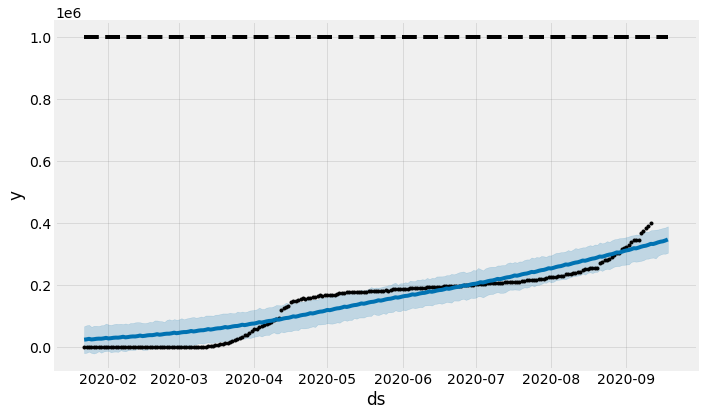

In [36]:
my_model.plot(forecast,
              uncertainty=True );

In [37]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [38]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,25062.401533,1000000.0,-18877.381215,67830.630807,25062.401533,25062.401533,-403.420362,-403.420362,-403.420362,-403.420362,-403.420362,-403.420362,0.0,0.0,0.0,24658.981171
1,2020-01-23,25477.234978,1000000.0,-17428.543441,70886.044398,25477.234978,25477.234978,187.506768,187.506768,187.506768,187.506768,187.506768,187.506768,0.0,0.0,0.0,25664.741746
2,2020-01-24,25898.752354,1000000.0,-13785.296074,72128.154171,25898.752354,25898.752354,1417.972310,1417.972310,1417.972310,1417.972310,1417.972310,1417.972310,0.0,0.0,0.0,27316.724664
3,2020-01-25,26327.055274,1000000.0,-18083.470349,65847.130186,26327.055274,26327.055274,-995.375952,-995.375952,-995.375952,-995.375952,-995.375952,-995.375952,0.0,0.0,0.0,25331.679322
4,2020-01-26,26762.246693,1000000.0,-19830.572298,69263.995336,26762.246693,26762.246693,-645.719042,-645.719042,-645.719042,-645.719042,-645.719042,-645.719042,0.0,0.0,0.0,26116.527651


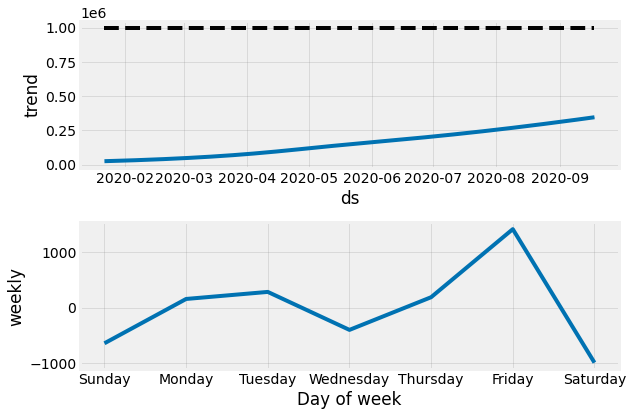

In [39]:
my_model.plot_components(forecast);

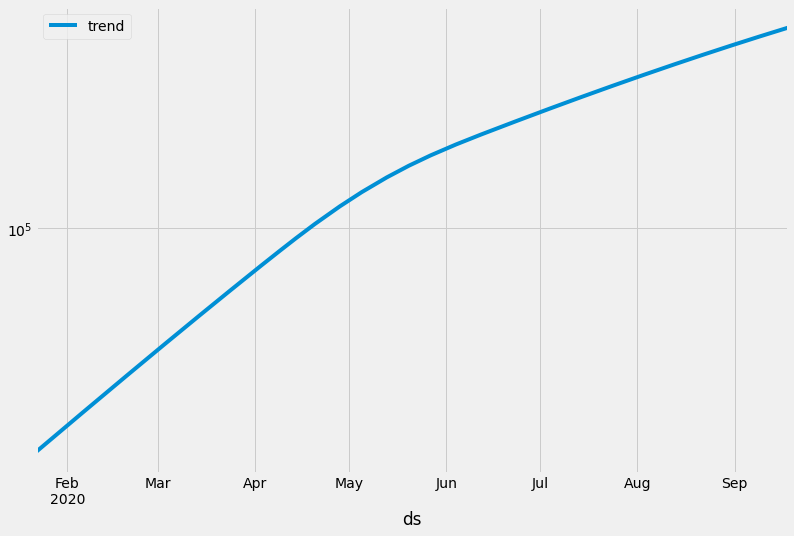

In [40]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

# Cross Validation

In [41]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future


INFO:fbprophet:Making 187 forecasts with cutoffs between 2020-03-02 00:00:00 and 2020-09-04 00:00:00


In [42]:
df_cv.sort_values(by=['cutoff','ds'])[0:14]
#df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-03,270.866833,261.773579,280.993762,204,2020-03-02
1,2020-03-04,390.240226,381.219736,399.909100,288,2020-03-02
2,2020-03-05,564.238358,554.428681,574.007801,380,2020-03-02
3,2020-03-06,813.726131,803.986578,823.096679,656,2020-03-02
4,2020-03-07,1176.713671,1167.744179,1186.590708,959,2020-03-02
5,2020-03-08,1692.418651,1682.511133,1701.941706,1136,2020-03-02
6,2020-03-09,2438.061644,2428.449248,2448.098504,1219,2020-03-02
7,2020-03-04,-9.022932,-15.479025,-2.324008,288,2020-03-03
8,2020-03-05,3.840128,-2.411366,10.777638,380,2020-03-03
9,2020-03-06,1.148917,-5.698392,7.872380,656,2020-03-03


In [43]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [44]:
df_p 

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.697846e+09,41204.930488,32937.016875,0.199459,0.204306,0.213904
1,2 days,1.988869e+09,44596.737255,36133.936388,0.223045,0.243219,0.219251
2,3 days,2.333490e+09,48306.207531,39722.360485,0.250340,0.269979,0.176471
3,4 days,2.734863e+09,52295.913045,43490.891585,0.277757,0.306106,0.165775
4,5 days,3.200792e+09,56575.539164,47577.186229,0.309494,0.332982,0.160428
5,6 days,3.745054e+09,61196.843250,51991.948235,0.344909,0.381857,0.144385
6,7 days,4.373033e+09,66128.915160,56718.154288,0.383812,0.410488,0.133690


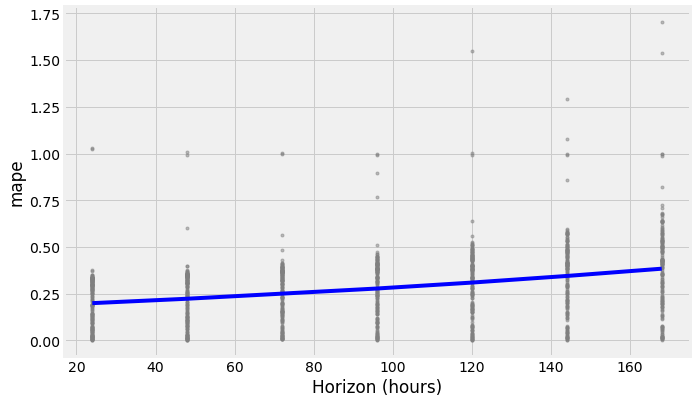

In [45]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonal plot

In [46]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [47]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
1280,2020-09-07,284840.093450,254235.337585,314707.419865,367174,2020-08-31,7 days
1287,2020-09-08,286684.146791,253959.089560,316560.932522,373718,2020-09-01,7 days
1294,2020-09-09,299825.722640,261969.976712,339086.941378,383292,2020-09-02,7 days
1301,2020-09-10,309579.985876,270850.579210,349636.009605,392243,2020-09-03,7 days
1308,2020-09-11,312546.031768,274006.404017,350581.489690,401890,2020-09-04,7 days


In [48]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

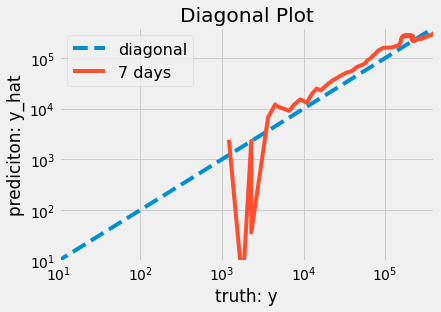

In [49]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forcast

In [50]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',parse_dates=parse_dates)
df_trivial=df_all[['date','France']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'France': 'y'})

# Rolling Mean

In [52]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [53]:
df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 274.5766029077601


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,2,0.666667,NaT,NaN,NaT
3,2020-01-25,3,1.666667,NaT,NaN,NaT
4,2020-01-26,3,2.666667,NaT,NaN,NaT
5,2020-01-27,3,3.000000,NaT,NaN,NaT
6,2020-01-28,4,3.333333,NaT,NaN,NaT
7,2020-01-29,5,4.000000,2020-01-22,NaN,7 days
8,2020-01-30,5,4.666667,2020-01-23,NaN,7 days
9,2020-01-31,5,5.000000,2020-01-24,0.666667,7 days
